In [4]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zf30vri5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zf30vri5
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=c1f0c389f3053299472a830caea5c3f285af082efea2e51c4ec705833d432fe7
  Stored in directory: /tmp/pip-ephem-wheel-cache-o73u9d7f/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [6]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPTokenizer
import torchvision.transforms as transforms
import clip


class DatasetLoader(Dataset):
    def __init__(self, image_paths, descriptions,tokens):
        self.image_paths = image_paths
        self.descriptions = descriptions
        self.tokens = tokens

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize images to the desired size
            transforms.ToTensor(),          # Convert image to tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize if needed
        ])
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        token_ids = self.tokens['input_ids'][idx]
        return image, self.descriptions[idx], token_ids


# Define the paths
data_dir = '/kaggle/input/merdead/merged'
csv_file = '/kaggle/input/merdead/cleaned_merged.csv'

# Load the CSV file
df = pd.read_csv(csv_file,nrows=1136)
# df['text'] = df['title'] + ' ' + df['color'] + ' ' + df['fabric'] #+ ' ' + df['designtype']

images = []
text = df['description'].tolist()

model,preprocessor = clip.load("ViT-B/32",device = "cuda")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
max_length = 77
# Tokenize the text
tokens = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")


# Iterate through the DataFrame to load images
for index, row in df.iterrows():
    image_filename = row['id']  # Assuming the CSV has a column named 'image_filename'

    # Load the image
    image_path = os.path.join(data_dir, str(image_filename) + '.jpg' ,)
    image = Image.open(image_path)

    images.append(image)

# Prepare dataset and dataloader
dataset = DatasetLoader(
    image_paths=[os.path.join(data_dir, str(img) + '.jpg') for img in df['id']],
    descriptions=df['description'].tolist(),
    tokens=tokens,
)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)


In [7]:
print(f"Total number of samples: {len(dataloader)}")
for step,(images, descriptions, token_ids) in enumerate(dataloader):
    # print(f"Batch {step + 1}")

    # Check the shape of the images tensor
    print(f"Images shape: {images.size()}")

    # Print the first description in the batch
    print(f"First description: {descriptions[0]}")

    # Check the shape of the tokens tensor
    print(f"Tokens shape: {token_ids.size()}")

    # Break after first batch to prevent printing too much information
    break

Total number of samples: 71
Images shape: torch.Size([16, 3, 224, 224])
First description: White Embroidered Readymade Groom's Sherwani In Silk White Silk
Tokens shape: torch.Size([16, 77])


In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F

class CLIP_IMG_ENCODER(nn.Module):
    def __init__(self, CLIP):
        super(CLIP_IMG_ENCODER, self).__init__()
        model = CLIP.visual
        # print(model)
        self.define_module(model)
        for param in self.parameters():
            param.requires_grad = False

    def define_module(self, model):
        self.conv1 = model.conv1
        self.class_embedding = model.class_embedding
        self.positional_embedding = model.positional_embedding
        self.ln_pre = model.ln_pre
        self.transformer = model.transformer
        self.ln_post = model.ln_post
        self.proj = model.proj

    @property
    def dtype(self):
        return self.conv1.weight.dtype

    def transf_to_CLIP_input(self,inputs):
        device = inputs.device
        if len(inputs.size()) != 4:
            raise ValueError('Expect the (B, C, X, Y) tensor.')
        else:
            mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])\
                .unsqueeze(-1).unsqueeze(-1).unsqueeze(0).to(device)
            var = torch.tensor([0.26862954, 0.26130258, 0.27577711])\
                .unsqueeze(-1).unsqueeze(-1).unsqueeze(0).to(device)
            inputs = F.interpolate(inputs*0.5+0.5, size=(224, 224))
            inputs = ((inputs+1)*0.5-mean)/var
            return inputs

    def forward(self, img: torch.Tensor):
        x = self.transf_to_CLIP_input(img)
        x = x.type(self.dtype)
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        grid =  x.size(-1)
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)
        # NLD -> LND
        x = x.permute(1, 0, 2)
        # Local features
        #selected = [1,4,7,12]
        selected = [1,4,8]
        local_features = []
        for i in range(12):
            x = self.transformer.resblocks[i](x)
            if i in selected:
                local_features.append(x.permute(1, 0, 2)[:, 1:, :].permute(0, 2, 1).reshape(-1, 768, grid, grid).contiguous().type(img.dtype))
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_post(x[:, 0, :])
        if self.proj is not None:
            x = x @ self.proj
        return torch.stack(local_features, dim=1), x.type(img.dtype)


# model,preprocessor = clip.load("ViT-B/32",device = "cpu")
# encoder = CLIP_IMG_ENCODER(model)

In [8]:
class CLIP_TXT_ENCODER(nn.Module):
    def __init__(self, CLIP):
        super(CLIP_TXT_ENCODER, self).__init__()
        self.define_module(CLIP)
        # print(model)
        for param in self.parameters():
            param.requires_grad = False

    def define_module(self, CLIP):
        self.transformer = CLIP.transformer
        self.vocab_size = CLIP.vocab_size
        self.token_embedding = CLIP.token_embedding
        self.positional_embedding = CLIP.positional_embedding
        self.ln_final = CLIP.ln_final
        self.text_projection = CLIP.text_projection
        self.context_length = self.positional_embedding.shape[0]

    @property
    def dtype(self):
        return self.transformer.resblocks[0].mlp.c_fc.weight.dtype

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]
        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        sent_emb = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection
        return sent_emb, x

In [9]:
import torch.nn.functional as F

class G_Block(nn.Module):
    def __init__(self, cond_dim, in_ch, out_ch, imsize):
        super(G_Block, self).__init__()
        self.imsize = imsize
        self.learnable_sc = in_ch != out_ch
        self.c1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        self.c2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
        self.fuse1 = DFBLK(cond_dim, in_ch)
        self.fuse2 = DFBLK(cond_dim, out_ch)
        if self.learnable_sc:
            self.c_sc = nn.Conv2d(in_ch,out_ch, 1, stride=1, padding=0)

    def shortcut(self, x):
        if self.learnable_sc:
            x = self.c_sc(x)
        return x

    def residual(self, h, y):
        h = self.fuse1(h, y)
        h = self.c1(h)
        h = self.fuse2(h, y)
        h = self.c2(h)
        return h

    def forward(self, h, y):
        h = F.interpolate(h, size=(self.imsize, self.imsize))
        return self.shortcut(h) + self.residual(h, y)


class D_Block(nn.Module):
    def __init__(self, fin, fout, k, s, p, res, CLIP_feat):
        super(D_Block, self).__init__()
        self.res, self.CLIP_feat = res, CLIP_feat
        self.learned_shortcut = (fin != fout)
        self.conv_r = nn.Sequential(
            nn.Conv2d(fin, fout, k, s, p, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(fout, fout, k, s, p, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            )
        self.conv_s = nn.Conv2d(fin, fout, 1, stride=1, padding=0)
        if self.res==True:
            self.gamma = nn.Parameter(torch.zeros(1))
        if self.CLIP_feat==True:
            self.beta = nn.Parameter(torch.zeros(1))

    def forward(self, x, CLIP_feat=None):
        res = self.conv_r(x)
        if self.learned_shortcut:
            x = self.conv_s(x)
        
        if (self.res==True)and(self.CLIP_feat==True):
            return x + self.gamma*res + self.beta*CLIP_feat
        elif (self.res==True)and(self.CLIP_feat!=True):
            return x + self.gamma*res
        elif (self.res!=True)and(self.CLIP_feat==True):
            return x + self.beta*CLIP_feat
        else:
            return x


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)



class Affine(nn.Module):
    def __init__(self, cond_dim, num_features):
        super(Affine, self).__init__()

        self.fc_gamma = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(cond_dim, num_features)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(num_features, num_features)),
            ]))
        self.fc_beta = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(cond_dim, num_features)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(num_features, num_features)),
            ]))
        self._initialize()

    def _initialize(self):
        nn.init.zeros_(self.fc_gamma.linear2.weight.data)
        nn.init.ones_(self.fc_gamma.linear2.bias.data)
        nn.init.zeros_(self.fc_beta.linear2.weight.data)
        nn.init.zeros_(self.fc_beta.linear2.bias.data)

    def forward(self, x, y=None):
        weight = self.fc_gamma(y)
        bias = self.fc_beta(y)

        if weight.dim() == 1:
            weight = weight.unsqueeze(0)
        if bias.dim() == 1:
            bias = bias.unsqueeze(0)

        size = x.size()
        weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
        bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)
        return weight * x + bias


class DFBLK(nn.Module):
    def __init__(self, cond_dim, in_ch):
        super(DFBLK, self).__init__()
        self.affine0 = Affine(cond_dim, in_ch)
        self.affine1 = Affine(cond_dim, in_ch)

    def forward(self, x, y=None):
        h = self.affine0(x, y)
        h = nn.LeakyReLU(0.2,inplace=True)(h)
        h = self.affine1(h, y)
        h = nn.LeakyReLU(0.2,inplace=True)(h)
        return h


class M_Block(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch, cond_dim, k, s, p):
        super(M_Block, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, mid_ch, k, s, p)
        self.fuse1 = DFBLK(cond_dim, mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, k, s, p)
        self.fuse2 = DFBLK(cond_dim, out_ch)
        self.learnable_sc = in_ch != out_ch
        if self.learnable_sc:
            self.c_sc = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)

    def shortcut(self, x):
        if self.learnable_sc:
            x = self.c_sc(x)
        return x

    def residual(self, h, text):
        h = self.conv1(h)
        h = self.fuse1(h, text)
        h = self.conv2(h)
        h = self.fuse2(h, text)
        return h

    def forward(self, h, c):
        return self.shortcut(h) + self.residual(h, c)



In [10]:
class CLIP_Mapper(nn.Module):
  def __init__(self,CLIP):
    super(CLIP_Mapper, self).__init__()
    model = CLIP.visual
    # print(model)
    self.define_module(model)
    for param in self.parameters():
      param.requires_grad = False

  def define_module(self,model):
    self.conv1 = model.conv1
    self.class_embedding = model.class_embedding
    self.positional_embedding = model.positional_embedding
    self.ln_pre = model.ln_pre
    self.transformer = model.transformer

  @property
  def dtype(self):
    return self.conv1.weight.dtype


  def forward(self,img:torch.Tensor,prompts:torch.Tensor):
    x = img.type(self.dtype)
    prompts = prompts.type(self.dtype)
    grid = x.size(-1)
    x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
    x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
    x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)
    # shape = [*, grid ** 2 + 1, width]
    x = x + self.positional_embedding.to(x.dtype)
    x = self.ln_pre(x)
    # NLD -> LND
    x = x.permute(1, 0, 2)
    # Local features
    selected = [1,2,3,4,5,6,7,8]
    begin,end = 0 , 12
    prompt_idx = 0
    for i in range(begin, end):
            if i in selected:
                prompt = prompts[:,prompt_idx,:].unsqueeze(0)
                prompt_idx = prompt_idx+1
                x = torch.cat((x,prompt), dim=0)
                x = self.transformer.resblocks[i](x)
                x = x[:-1,:,:]
            else:
                x = self.transformer.resblocks[i](x)
    return x.permute(1, 0, 2)[:, 1:, :].permute(0, 2, 1).reshape(-1, 768, grid, grid).contiguous().type(img.dtype)

class CLIP_Adapter(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch, G_ch, CLIP_ch, cond_dim, k, s, p, map_num, CLIP):
        super(CLIP_Adapter, self).__init__()
        self.CLIP_ch = CLIP_ch
        self.FBlocks = nn.ModuleList([])
        self.FBlocks.append(M_Block(in_ch, mid_ch, out_ch, cond_dim, k, s, p))
        for i in range(map_num-1):
            self.FBlocks.append(M_Block(out_ch, mid_ch, out_ch, cond_dim, k, s, p))
        self.conv_fuse = nn.Conv2d(out_ch, CLIP_ch, 5, 1, 2)
        self.CLIP_ViT = CLIP_Mapper(CLIP)
        self.conv = nn.Conv2d(768, G_ch, 5, 1, 2)
        #
        self.fc_prompt = nn.Linear(cond_dim, CLIP_ch*8)

    def forward(self,out,c):
        prompts = self.fc_prompt(c).view(c.size(0),-1,self.CLIP_ch)
        for FBlock in self.FBlocks:
            out = FBlock(out,c)
        fuse_feat = self.conv_fuse(out)
        map_feat = self.CLIP_ViT(fuse_feat,prompts)
        return self.conv(fuse_feat+0.1*map_feat)

In [11]:
from collections import OrderedDict
import numpy as np

class NetG(nn.Module):
  def __init__(self,ngf,nz,cond_dim,imsize,ch_size,mixed_precision,CLIP):
    super(NetG, self).__init__()
    self.ngf = ngf
    self.mixed_precision = mixed_precision
    self.code_sz,self.code_ch,self.mid_ch = 7,64,32
    self.CLIP_ch = 768
    self.fc_code = nn.Linear(nz,self.code_sz*self.code_sz*self.code_ch)
    self.mapping = CLIP_Adapter(self.code_ch, self.mid_ch, self.code_ch, ngf*8, self.CLIP_ch, cond_dim+nz, 3, 1, 1, 4, CLIP)
    self.GBlocks = nn.ModuleList([])
    in_out_pairs = list(get_G_in_out_chs(ngf, imsize))
    imsize = 4
    for idx, (in_ch, out_ch) in enumerate(in_out_pairs):
        if idx<(len(in_out_pairs)-1):
            imsize = imsize*2
        else:
            imsize = 224
        self.GBlocks.append(G_Block(cond_dim+nz, in_ch, out_ch, imsize))
    self.to_rgb = nn.Sequential(
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(out_ch, ch_size, 3, 1, 1),
    )

  def forward(self, noise, c, eval=False):
    with torch.cuda.amp.autocast() if self.mixed_precision and not eval else dummy_context_mgr() as mp:
      cond = torch.cat((noise, c), dim=1)
      out = self.mapping(self.fc_code(noise).view(noise.size(0), self.code_ch, self.code_sz, self.code_sz), cond)
      # fuse text and visual features
      for GBlock in self.GBlocks:
          out = GBlock(out, cond)
      # convert to RGB image
      out = self.to_rgb(out)
    return out


In [12]:
class NetD(nn.Module):
    def __init__(self, ndf, imsize, ch_size, mixed_precision):
        super(NetD, self).__init__()
        self.mixed_precision = mixed_precision
        self.DBlocks = nn.ModuleList([
            D_Block(768, 768, 3, 1, 1, res=True, CLIP_feat=True),
            D_Block(768, 768, 3, 1, 1, res=True, CLIP_feat=True),
        ])
        self.main = D_Block(768, 512, 3, 1, 1, res=True, CLIP_feat=False)

    def forward(self, h):
        with torch.cuda.amp.autocast() if self.mixed_precision else dummy_context_mgr() as mpc:
            out = h[:,0]
            for idx in range(len(self.DBlocks)):
                out = self.DBlocks[idx](out, h[:,idx+1])
            out = self.main(out)
        return out

In [13]:
class NetC(nn.Module):
    def __init__(self, ndf, cond_dim, mixed_precision):
        super(NetC, self).__init__()
        self.cond_dim = cond_dim
        self.mixed_precision = mixed_precision
        self.joint_conv = nn.Sequential(
            nn.Conv2d(512+512, 128, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            )

    def forward(self, out, cond):
        with torch.cuda.amp.autocast() if self.mixed_precision else dummy_context_mgr() as mpc:
            cond = cond.view(-1, self.cond_dim, 1, 1)
            cond = cond.repeat(1, 1, 7, 7)
            h_c_code = torch.cat((out, cond), 1)
            out = self.joint_conv(h_c_code)
        return out

In [14]:
def get_G_in_out_chs(nf, imsize):
    layer_num = int(np.log2(imsize))-1
    channel_nums = [nf*min(2**idx, 8) for idx in range(layer_num)]
    channel_nums = channel_nums[::-1]
    in_out_pairs = zip(channel_nums[:-1], channel_nums[1:])
    return in_out_pairs


def get_D_in_out_chs(nf, imsize):
    layer_num = int(np.log2(imsize))-1
    channel_nums = [nf*min(2**idx, 8) for idx in range(layer_num)]
    in_out_pairs = zip(channel_nums[:-1], channel_nums[1:])
    return in_out_pairs

In [15]:
import torch.nn.functional as F
from torch import distributed as dist
import torch

def prepare_data(data, text_encoder, device):
    imgs, captions, CLIP_tokens = data
    imgs, CLIP_tokens = imgs.to(device), CLIP_tokens.to(device)
    sent_emb, words_embs = encode_tokens(text_encoder, CLIP_tokens)
    return imgs, captions, CLIP_tokens, sent_emb, words_embs


def encode_tokens(text_encoder, caption):
    # encode text
    with torch.no_grad():
        sent_emb,words_embs = text_encoder(caption)
        sent_emb,words_embs = sent_emb.detach(), words_embs.detach()
    return sent_emb, words_embs

def predict_loss(predictor, img_feature, text_feature, negtive):
    output = predictor(img_feature, text_feature)
    err = hinge_loss(output, negtive)
    return output,err


def hinge_loss(output, negtive):
    if negtive==False:
        err = torch.mean(F.relu(1. - output))
    else:
        err = torch.mean(F.relu(1. + output))
    return err

def get_rank():
    if not dist.is_available():
        return 0
    if not dist.is_initialized():
        return 0
    return dist.get_rank()


def MA_GP_MP(img, sent, out, scaler):
    grads = torch.autograd.grad(outputs=scaler.scale(out),
                            inputs=(img, sent),
                            grad_outputs=torch.ones_like(out),
                            retain_graph=True,
                            create_graph=True,
                            only_inputs=True)
    inv_scale = 1./(scaler.get_scale()+float("1e-8"))
    #inv_scale = 1./scaler.get_scale()
    grads = [grad * inv_scale for grad in grads]
    with torch.cuda.amp.autocast():
        grad0 = grads[0].view(grads[0].size(0), -1)
        grad1 = grads[1].view(grads[1].size(0), -1)
        grad = torch.cat((grad0,grad1),dim=1)
        grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
        d_loss_gp =  2.0 * torch.mean((grad_l2norm) ** 6)
    return d_loss_gp


def MA_GP_FP32(img, sent, out):
    grads = torch.autograd.grad(outputs=out,
                            inputs=(img, sent),
                            grad_outputs=torch.ones(out.size()).cuda(),
                            retain_graph=True,
                            create_graph=True,
                            only_inputs=True)
    grad0 = grads[0].view(grads[0].size(0), -1)
    grad1 = grads[1].view(grads[1].size(0), -1)
    grad = torch.cat((grad0,grad1),dim=1)
    grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
    d_loss_gp =  2.0 * torch.mean((grad_l2norm) ** 6)
    return d_loss_gp

class dummy_context_mgr():
    def __enter__(self):
        return None

    def __exit__(self, exc_type, exc_value, traceback):
        return False

In [17]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

if cuda_available:
    print("CUDA is available! Running on GPU.")
else:
    print("CUDA is not available. Running on CPU.")


CUDA is available! Running on GPU.


In [18]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# for images, descriptions, token_ids in dataloader:
#     images = images.to(device)  # Move images to the GPU
#     token_ids = token_ids.to(device)  # Move token IDs to the GPU

In [19]:
from tqdm import tqdm
import clip



def train(dataloader, netG, netD, netC, text_encoder, image_encoder, optimizerG, optimizerD, scaler_G, scaler_D, args):
    batch_size = args.batch_size
    device = args.device
    epoch = args.current_epoch
    max_epoch = args.max_epoch
    
    z_dim = args.z_dim
    netG, netD, netC, image_encoder = netG.train(), netD.train(), netC.train(), image_encoder.train()
    if (args.multi_gpus==True) and (get_rank() != 0):
        None
    else:
        loop = tqdm(total=len(dataloader))
    total_loss_D = 0.0
    total_loss_G = 0.0
    num_batches = len(dataloader)
    for step, data in enumerate(dataloader, 0):
        ##############
        # Train D
        ##############
        optimizerD.zero_grad()
        with torch.cuda.amp.autocast() if args.mixed_precision else dummy_context_mgr() as mpc:
            # prepare_data
            real, captions, CLIP_tokens, sent_emb, words_embs= prepare_data(data, text_encoder, device)
            real = real.requires_grad_()
            sent_emb = sent_emb.requires_grad_()
            words_embs = words_embs.requires_grad_()
            # predict real
            CLIP_real,real_emb = image_encoder(real)
            real_feats = netD(CLIP_real)
            pred_real, errD_real = predict_loss(netC, real_feats, sent_emb, negtive=False)
            # predict mismatch
            mis_sent_emb = torch.cat((sent_emb[1:], sent_emb[0:1]), dim=0).detach()
            _, errD_mis = predict_loss(netC, real_feats, mis_sent_emb, negtive=True)
            # synthesize fake images
            noise = torch.randn(batch_size, z_dim).to(device)
            fake = netG(noise, sent_emb)
            CLIP_fake, fake_emb = image_encoder(fake)
            fake_feats = netD(CLIP_fake.detach())
            _, errD_fake = predict_loss(netC, fake_feats, sent_emb, negtive=True)
        # MA-GP
        if args.mixed_precision:
            errD_MAGP = MA_GP_MP(CLIP_real, sent_emb, pred_real, scaler_D)
        else:
            errD_MAGP = MA_GP_FP32(CLIP_real, sent_emb, pred_real)
        # whole D loss
        with torch.cuda.amp.autocast() if args.mixed_precision else dummy_context_mgr() as mpc:
            errD = errD_real + (errD_fake + errD_mis)/2.0 + errD_MAGP
        # update D
        if args.mixed_precision:
            scaler_D.scale(errD).backward()
            scaler_D.step(optimizerD)
            scaler_D.update()
            if scaler_D.get_scale()<args.scaler_min:
                scaler_D.update(16384.0)
        else:
            errD.backward()
            optimizerD.step()
        
        total_loss_D += errD.item()
        ##############
        # Train G
        ##############
        optimizerG.zero_grad()
        with torch.cuda.amp.autocast() if args.mixed_precision else dummy_context_mgr() as mpc:
            fake_feats = netD(CLIP_fake)
            output = netC(fake_feats, sent_emb)
            text_img_sim = torch.cosine_similarity(fake_emb, sent_emb).mean()
            errG = -output.mean() - args.sim_w*text_img_sim
        if args.mixed_precision:
            scaler_G.scale(errG).backward()
            scaler_G.step(optimizerG)
            scaler_G.update()
            if scaler_G.get_scale()<args.scaler_min:
                scaler_G.update(16384.0)
        else:
            errG.backward()
            optimizerG.step()
        total_loss_G += errG.item()
        # update loop information
        if (args.multi_gpus==True) and (get_rank() != 0):
            None
        else:
            loop.update(1)
            loop.set_description(f'Train Epoch [{epoch}/{max_epoch}]')
            loop.set_postfix()
        
    if (args.multi_gpus==True) and (get_rank() != 0):
        None
    else:
        loop.close()
    avg_loss_D = total_loss_D / num_batches
    avg_loss_G = total_loss_G / num_batches
    return avg_loss_D, avg_loss_G

def save_model(netG, netD, netC, optG, optD, epoch, multi_gpus, step, save_path):
    if (multi_gpus == True) and (get_rank() != 0):
        return  # Only the main process saves the model in multi-GPU setups
    else:
        # Create a state dictionary to save the model and optimizer states
        state = {
            'model': {
                'netG': netG.state_dict(),
                'netD': netD.state_dict(),
                'netC': netC.state_dict()
            },
            'optimizers': {
                'optimizer_G': optG.state_dict(),
                'optimizer_D': optD.state_dict()
            },
            'epoch': epoch
        }
        # Save the state dictionary to a file
        torch.save(state, f'{save_path}/state_epoch_{epoch:03d}_{step:03d}.pth')

In [20]:
model,preprocessor = clip.load("ViT-B/32",device = "cuda")

In [23]:
from argparse import Namespace


# Initialize models
ngf = 64       # Number of generator filters
nz = 100       # Latent vector size (noise)
cond_dim = 512 # Dimension of text embedding (conditional input)
imsize = 224   # Image size (final resolution)
ch_size = 3    # Output image channels (RGB)
mixed_precision = True # Whether to use mixed precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLIP = model # Assuming you have a CLIP model instance

# Discriminator parameters
ndf = 64



netG = NetG(ngf, nz, cond_dim, imsize, ch_size, mixed_precision, CLIP)
netD = NetD(ndf, imsize, ch_size, mixed_precision)
netC = NetC(ndf, cond_dim, mixed_precision)
text_encoder = CLIP_TXT_ENCODER(CLIP)
image_encoder = CLIP_IMG_ENCODER(CLIP)
netD.float().to(device)
netC.float().to(device)
netG.float().to(device)
# Initialize optimizers and scalers
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001 ,betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0004 ,betas=(0.0, 0.9))
scaler_G = torch.cuda.amp.GradScaler()
scaler_D = torch.cuda.amp.GradScaler()

# Set training arguments
args = Namespace(
    batch_size=16,
    device='cuda',
    current_epoch=1,
    max_epoch=100,
    z_dim=100,
    multi_gpus=True,
    mixed_precision=True,
    scaler_min=1.0,
    sim_w=4.0
)
max_epochs = 100
# Train your model
for epoch in range(max_epochs):
        args.current_epoch = epoch  # Update the current epoch in args
        avg_loss_D, avg_loss_G =train(dataloader, netG, netD, netC, text_encoder, image_encoder, optimizerG, optimizerD, scaler_G, scaler_D, args)
        if epoch % 10 == 0 or epoch == max_epochs - 1:
            save_model(netG, netD, netC, optimizerG, optimizerD, epoch, args.multi_gpus, step, '/kaggle/working/')
        print(f'Epoch {epoch}/{args.max_epoch} - Avg Loss D: {avg_loss_D:.4f}, Avg Loss G: {avg_loss_G:.4f}')

In [2]:
def load_model(netG, netD, netC, optG, optD, load_path):
    checkpoint = torch.load(load_path,map_location=torch.device("cuda"))
    netG.load_state_dict(checkpoint['model']['netG'])
    netD.load_state_dict(checkpoint['model']['netD'])
    netC.load_state_dict(checkpoint['model']['netC'])
    optG.load_state_dict(checkpoint['optimizers']['optimizer_G'])
    optD.load_state_dict(checkpoint['optimizers']['optimizer_D'])
    return checkpoint['epoch']

# Example usage:
epoch = load_model(netG, netD, netC, optimizerG, optimizerD, '/kaggle/working/state_epoch_001_000.pth')

NameError: name 'netG' is not defined

In [22]:
save_model(netG, netD, netC, optimizerG, optimizerD, 1, args.multi_gpus, step, '/kaggle/working/')

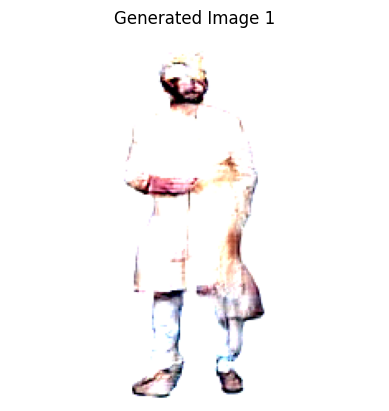

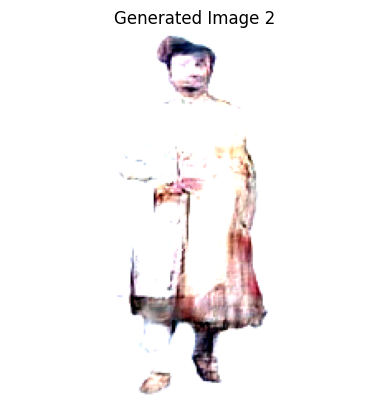

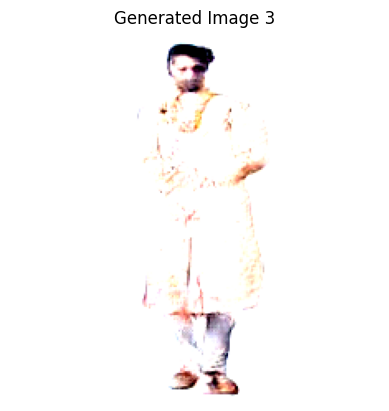

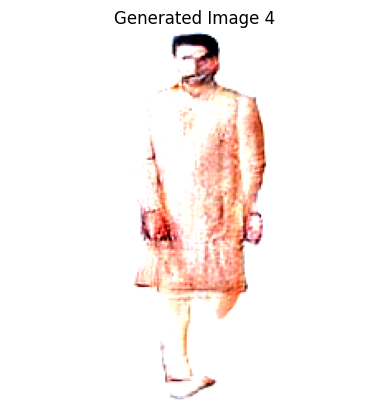

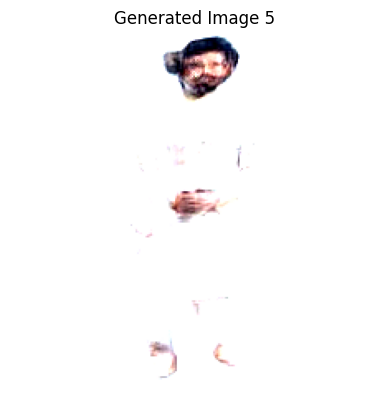

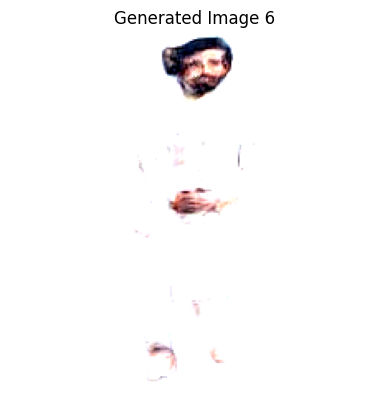

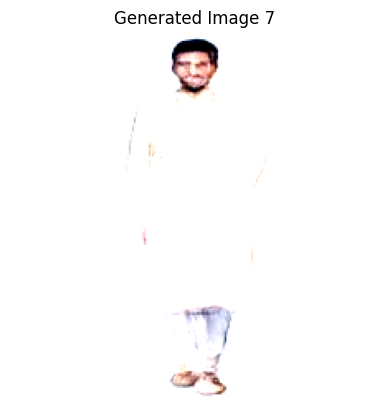

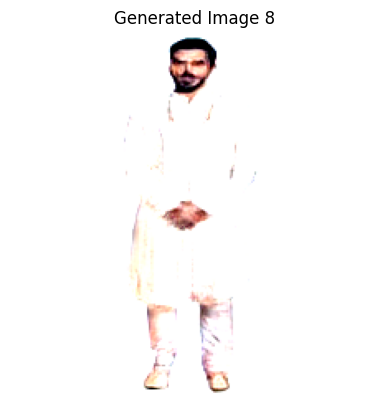

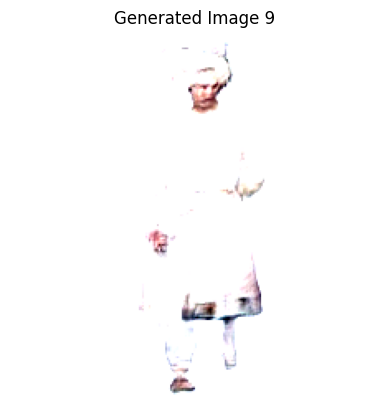

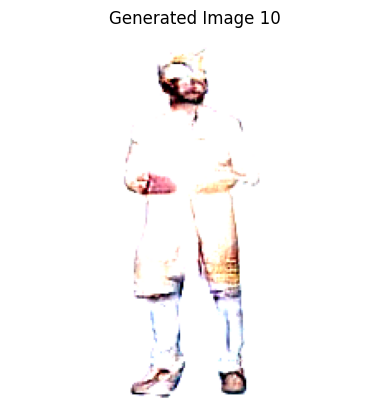

Images saved and zipped at: /kaggle/working/generated_images.zip


In [31]:
device="cuda"
caption = "All Over Dori Embroidered Sherwani Gold  Silk silk"
tokens = tokenizer(caption, padding='max_length', truncation=True, max_length=77, return_tensors="pt")
input_ids = tokens.input_ids.to(device)
test_model(netG, text_encoder,input_ids, device,caption)

In [20]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import shutil
import os

def test_model(netG, text_encoder,input_ids,device,caption,num_samples=10):
    netG.eval()  # Set the generator to evaluation mode
    transform = transforms.ToPILImage()  # Convert the image tensor to PIL format
    save_dir='/kaggle/working/generated_images/'+list(caption)[0]
    os.makedirs(save_dir, exist_ok=True)
    with torch.no_grad():  # No need to calculate gradients during testing
        for i in range(num_samples):
            noise = torch.randn(1, args.z_dim).to(device)
            caption_emb,word_embeds = text_encoder(input_ids)
            fake_image = netG(noise, caption_emb)
            
            # Assuming the generated image is normalized [-1, 1], denormalize it to [0, 1]
            fake_image = (fake_image.squeeze(0) * 0.5 + 0.5).clamp(0, 1)
            
            # Convert to PIL image and display
            pil_image = transform(fake_image.cpu())
            image_path = os.path.join(save_dir, f"generated_image_{i+1}.png")
            pil_image.save(image_path)
            plt.imshow(pil_image)
            plt.title(f"Generated Image {i+1}")
            plt.axis('off')
            plt.show()
    zip_path = '/kaggle/working/generated_images.zip'
    shutil.make_archive(zip_path.replace('.zip', ''), 'zip', save_dir)
    print(f"Images saved and zipped at: {zip_path}")

# Example usage:
# test_model(netG, text_encoder,input_ids, device)

In [ ]:
device="cuda"
caption = "Blue Color Designer Indowestern"
tokens = tokenizer(caption, padding='max_length', truncation=True, max_length=77, return_tensors="pt")
input_ids = tokens.input_ids.to(device)
test_model(netG, text_encoder,input_ids, device)

In [39]:
save_model(netG, netD, netC, optimizerG, optimizerD, 1, args.multi_gpus, step, '/kaggle/working/')
epoch = load_model(netG, netD, netC, optimizerG, optimizerD, '/kaggle/input/sherwani180/pytorch/default/1/state_epoch_001_000-sherwani.pth')


In [1]:
epoch = load_model(netG, netD, netC, optimizerG, optimizerD, '/kaggle/input/sherwani180/pytorch/default/1/state_epoch_001_000-sherwani.pth')

NameError: name 'load_model' is not defined

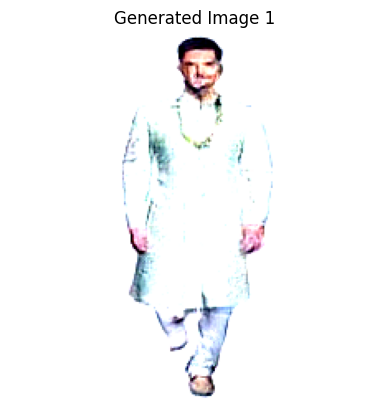

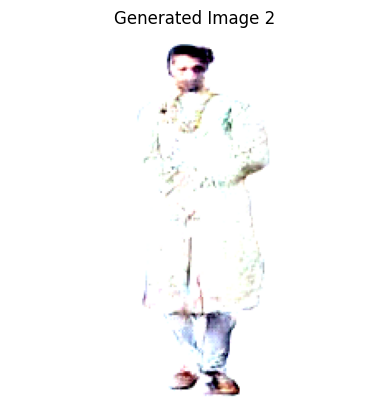

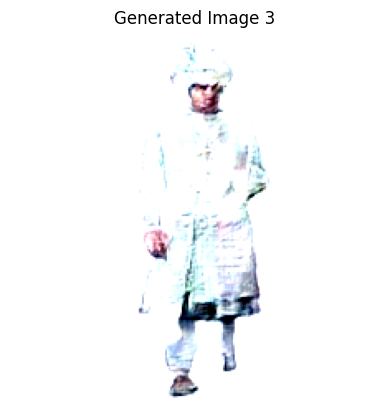

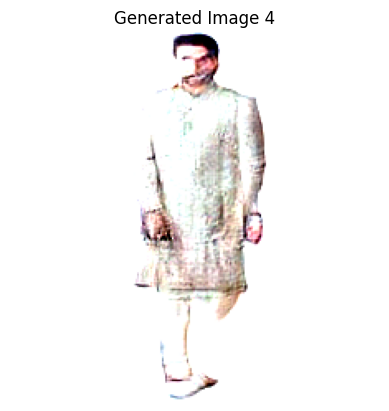

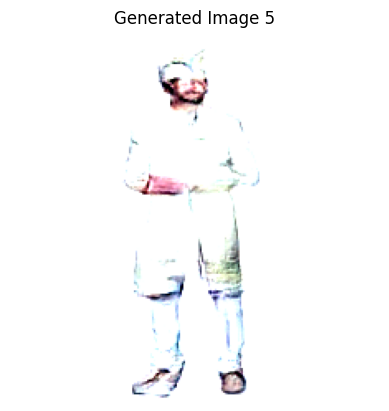

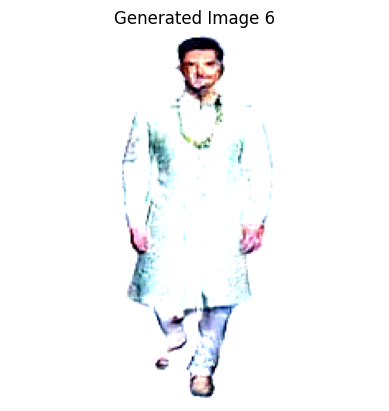

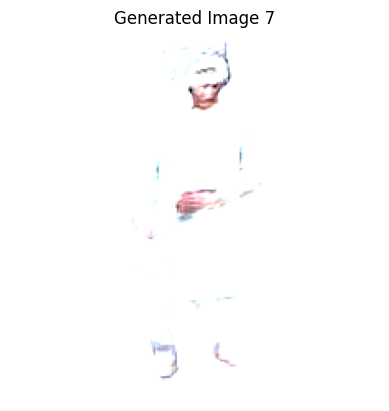

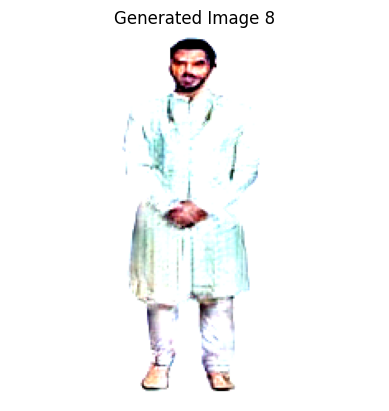

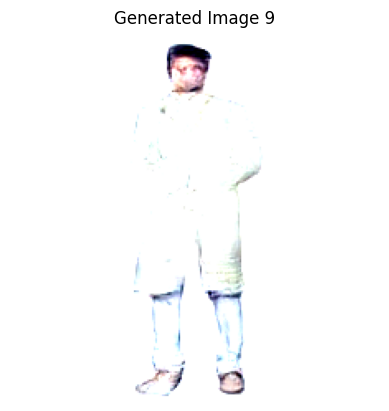

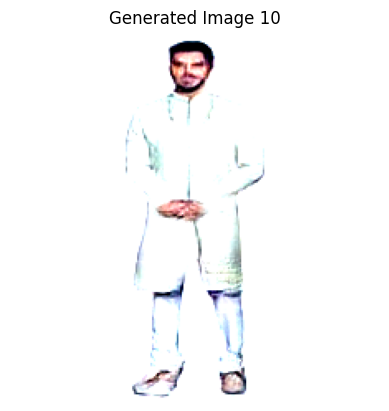

Images saved and zipped at: /kaggle/working/generated_images.zip


In [56]:
device="cuda"
caption = "Pista Green Wedding Wear Sherwani For Men Golden,  Pista Green Art Banarasi Silk,  Art Dupion Silk"
tokens = tokenizer(caption, padding='max_length', truncation=True, max_length=77, return_tensors="pt")
input_ids = tokens.input_ids.to(device)
test_model(netG, text_encoder,input_ids, device)

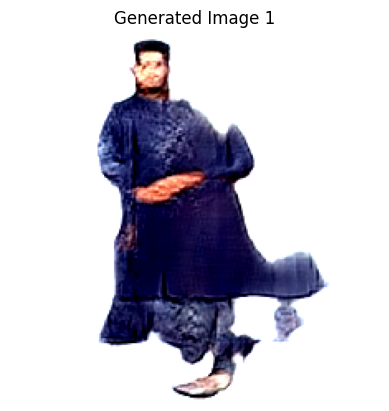

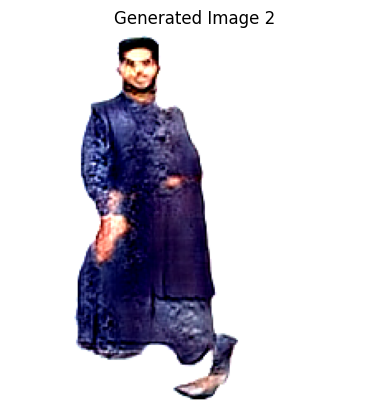

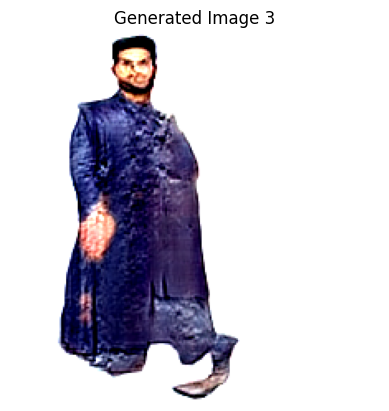

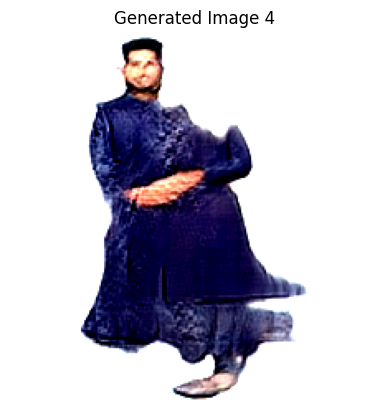

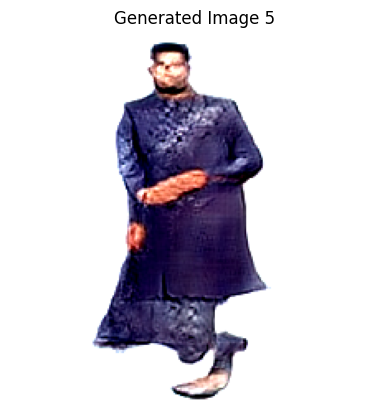

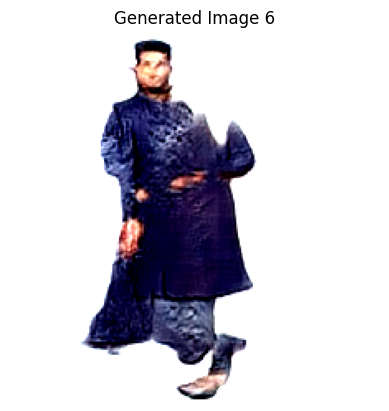

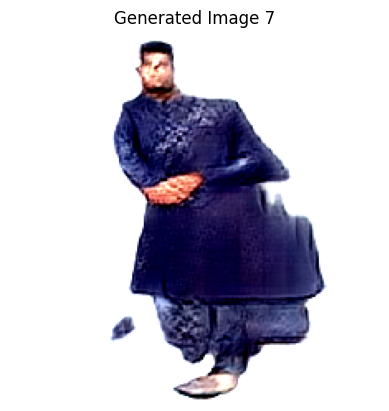

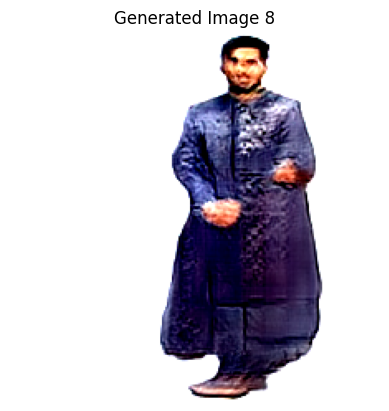

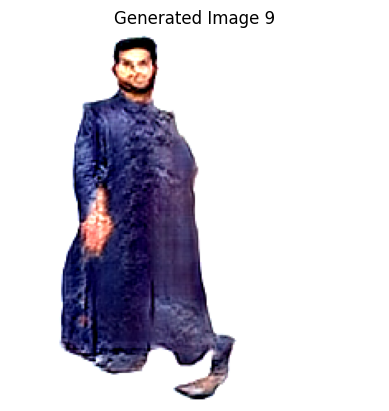

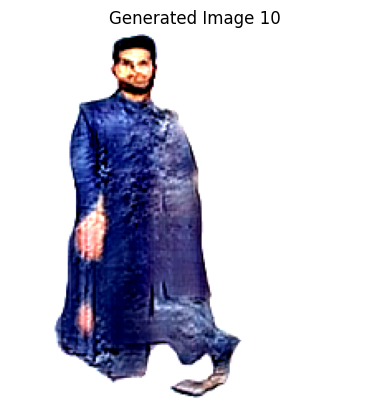

In [43]:
device="cuda"
caption = "Navy Blue Designer Art Banarasi Silk Sherwani Navy,"
tokens = tokenizer(caption, padding='max_length', truncation=True, max_length=77, return_tensors="pt")
input_ids = tokens.input_ids.to(device)
test_model(netG, text_encoder,input_ids, device)

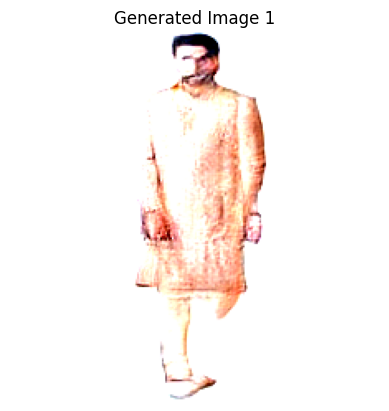

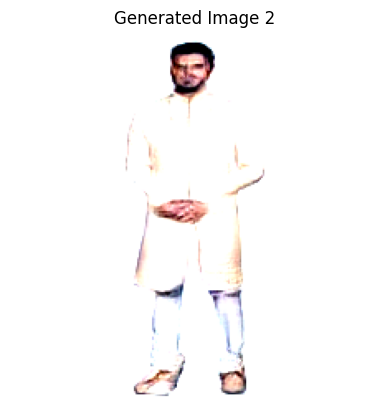

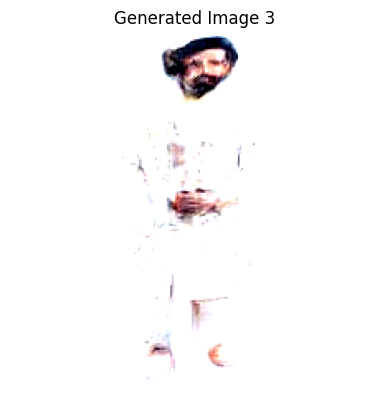

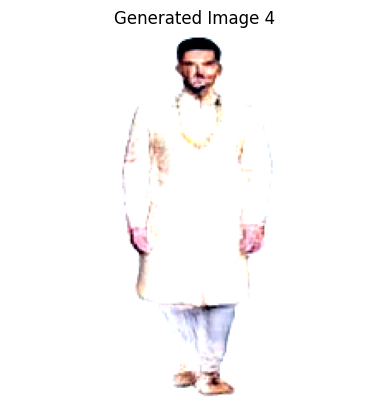

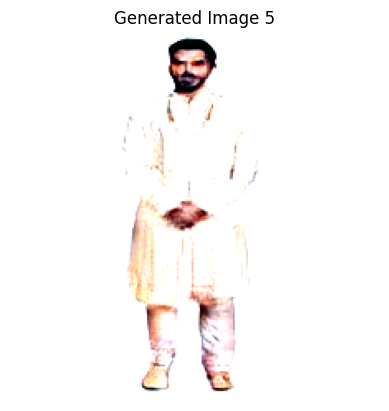

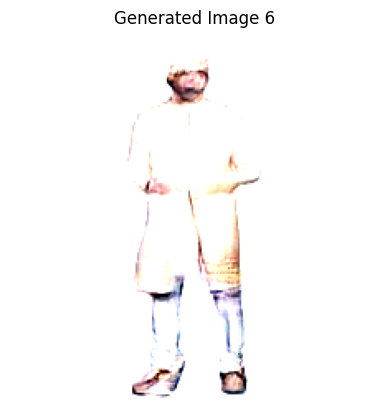

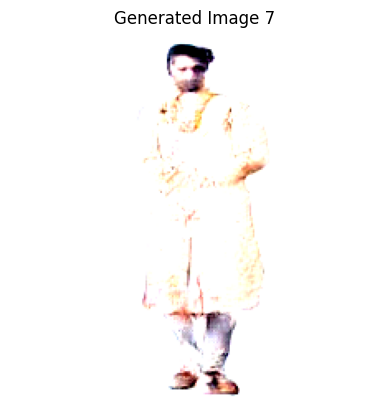

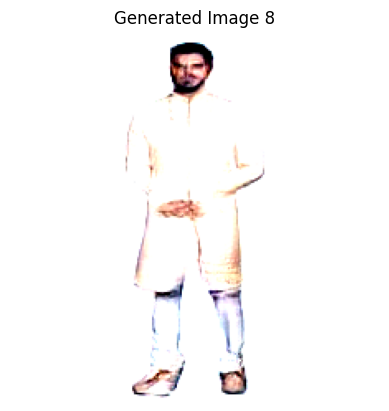

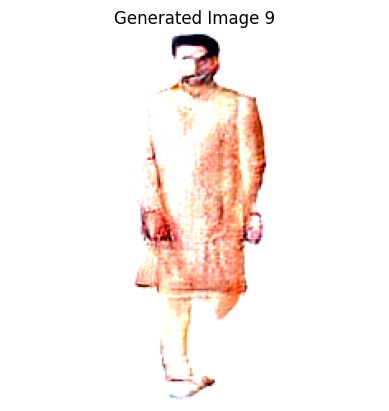

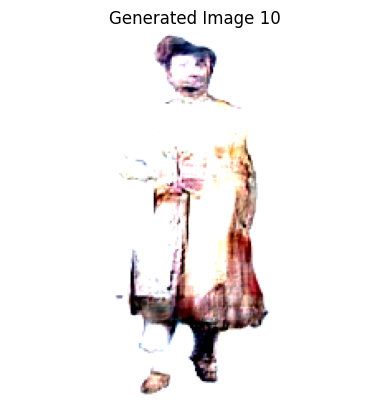

In [46]:
device="cuda"
caption = "Golden Colour Silk Wedding Sherwani With Zari,Thread,Hand Work. Golden Silk"
tokens = tokenizer(caption, padding='max_length', truncation=True, max_length=77, return_tensors="pt")
input_ids = tokens.input_ids.to(device)
test_model(netG, text_encoder,input_ids, device)

In [47]:
!nvidia-smi

Sat Aug 24 10:04:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             30W /   70W |    6077MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [48]:
!pip show accelerate

Name: accelerate
Version: 0.32.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /opt/conda/lib/python3.10/site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: catalyst


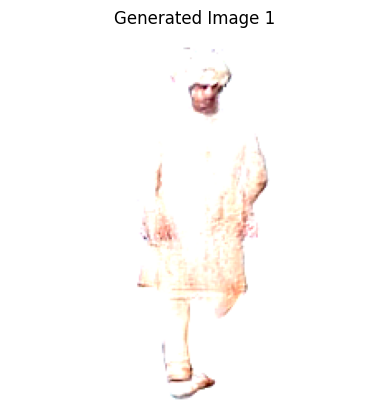

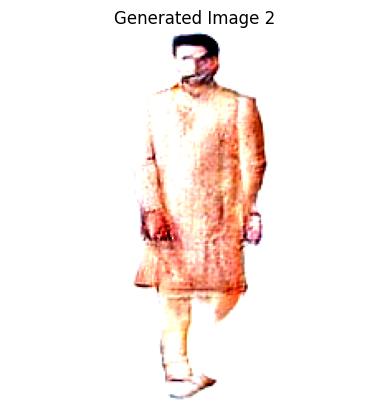

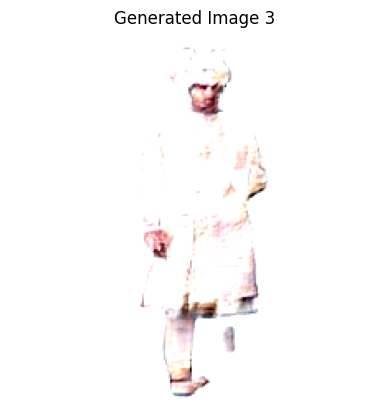

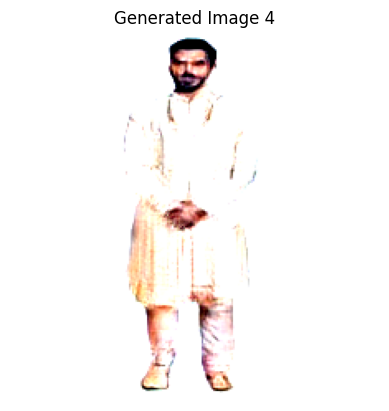

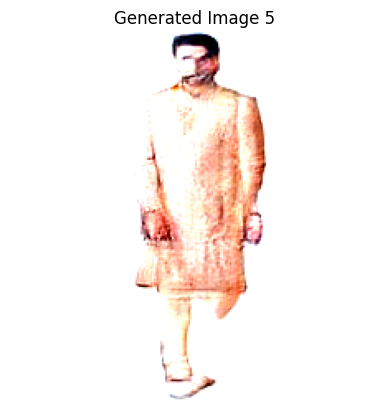

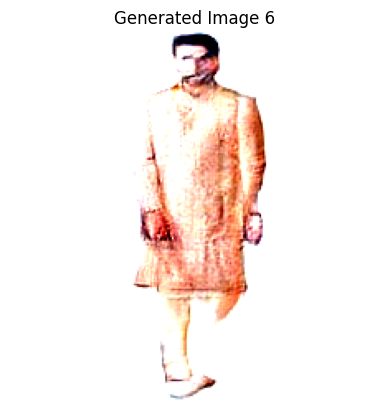

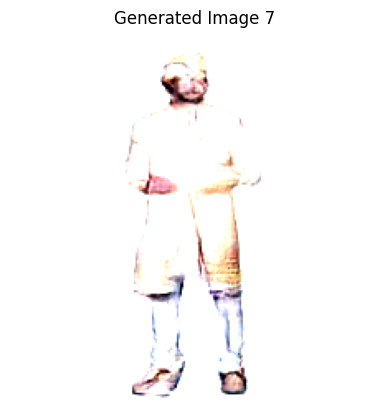

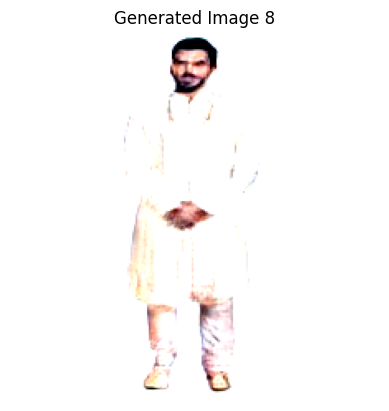

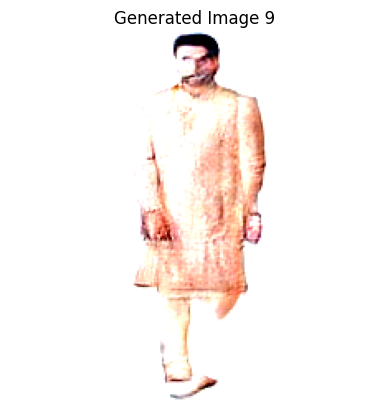

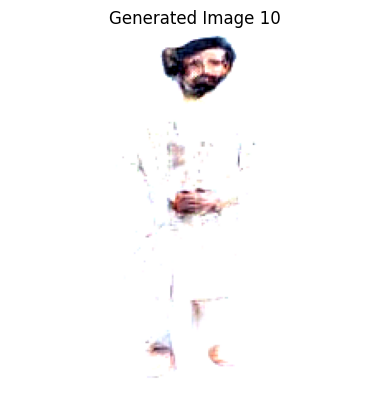

Images saved and zipped at: /kaggle/working/generated_images.zip


In [60]:
device="cuda"
caption = "Golden Sherwani for wedding"
tokens = tokenizer(caption, padding='max_length', truncation=True, max_length=77, return_tensors="pt")
input_ids = tokens.input_ids.to(device)
test_model(netG, text_encoder,input_ids, device,caption)

In [26]:
from argparse import Namespace
ngf = 64       # Number of generator filters
nz = 100       # Latent vector size (noise)
cond_dim = 512 # Dimension of text embedding (conditional input)
imsize = 224   # Image size (final resolution)
ch_size = 3    # Output image channels (RGB)
mixed_precision = True # Whether to use mixed precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLIP = model # Assuming you have a CLIP model instance

# Discriminator parameters
ndf = 64
args = Namespace(
    batch_size=16,
    device='cuda',
    current_epoch=1,
    max_epoch=80,
    z_dim=100,
    multi_gpus=True,
    mixed_precision=True,
    scaler_min=1.0,
    sim_w=4.0
)



netG = NetG(ngf, nz, cond_dim, imsize, ch_size, mixed_precision, CLIP)
netD = NetD(ndf, imsize, ch_size, mixed_precision)
netC = NetC(ndf, cond_dim, mixed_precision)
text_encoder = CLIP_TXT_ENCODER(CLIP)
image_encoder = CLIP_IMG_ENCODER(CLIP)
netD.float().to(device)
netC.float().to(device)
netG.float().to(device)
# Initialize optimizers and scalers
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001 ,betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0004 ,betas=(0.0, 0.9))
scaler_G = torch.cuda.amp.GradScaler()
scaler_D = torch.cuda.amp.GradScaler()

In [27]:
epoch = load_model(netG, netD, netC, optimizerG, optimizerD, '/kaggle/input/sherwani180/pytorch/default/1/state_epoch_001_000-sherwani.pth')

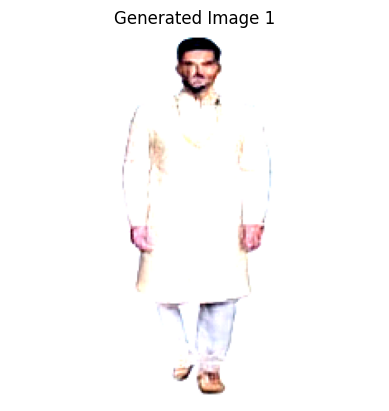

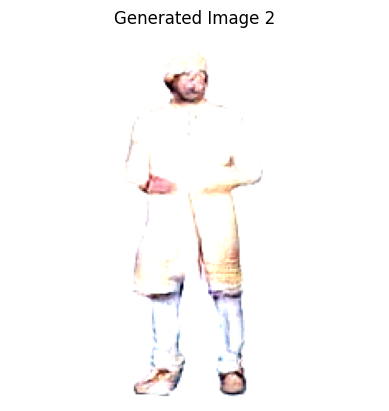

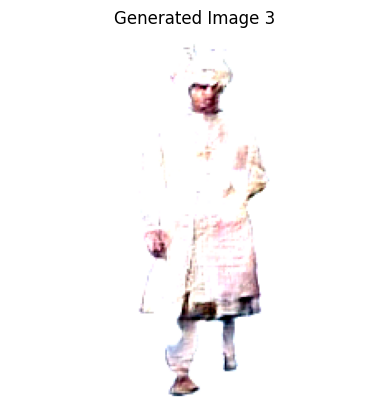

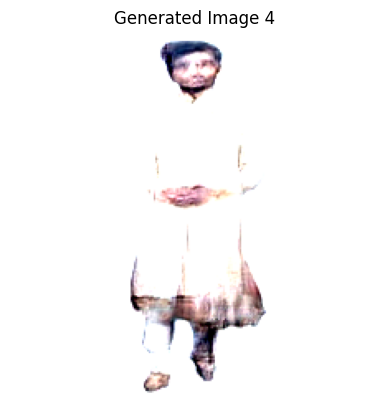

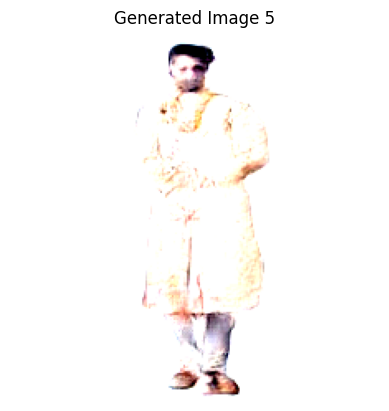

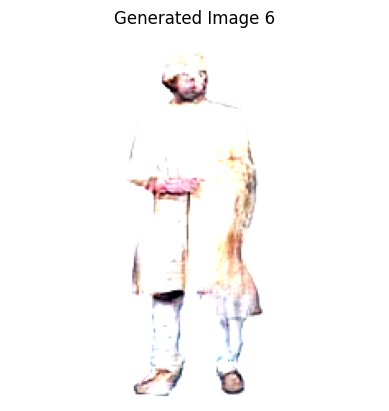

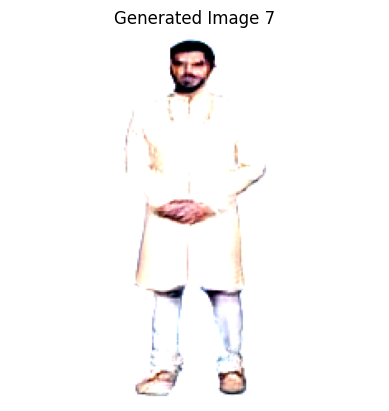

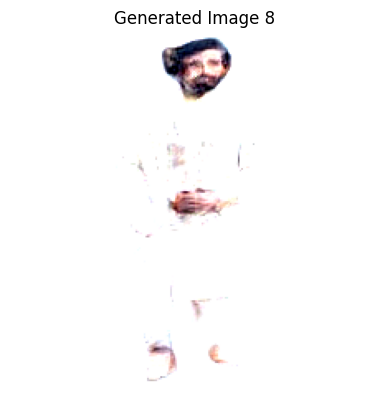

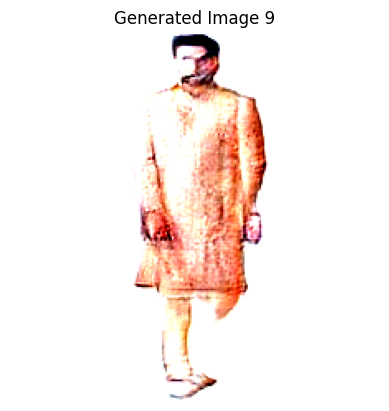

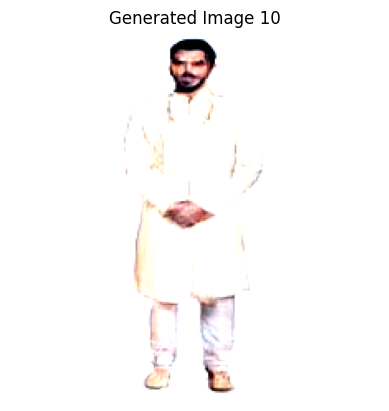

Images saved and zipped at: /kaggle/working/generated_images.zip


In [28]:
device="cuda"
caption = "Golden Sherwani for wedding"
tokens = tokenizer(caption, padding='max_length', truncation=True, max_length=77, return_tensors="pt")
input_ids = tokens.input_ids.to(device)
test_model(netG, text_encoder,input_ids, device,caption)